## Exploring the Correlation of Medical Charges with Health Factors

**Introduction**

In the realm of healthcare, understanding the factors influencing medical charges is crucial for effective resource allocation, policy-making, and personalized care delivery. This Jupyter notebook delves into an exploration of medical charges, seeking correlations with various demographic and health-related features.

The dataset under investigation comprises information on age, gender, body mass index (BMI), number of children covered by insurance, smoking habits, residential region, and individual medical charges. This comprehensive dataset offers a rich landscape for investigating potential relationships between these factors and the incurred medical expenses.

The data originates from a publicly available source and has been preprocessed to ensure consistency and compatibility with the analysis tools employed herein. By leveraging machine learning techniques and statistical analysis, we aim to uncover insights into how factors such as age, gender, BMI, smoking habits, and geographic location may influence medical charges.

Through this exploration, we seek to not only identify correlations but also contribute to the broader understanding of healthcare economics and the drivers of medical costs. By shedding light on these relationships, we aspire to inform healthcare policy, improve risk assessment, and enhance the efficiency of healthcare resource allocation.

**Data Source ->** https://www.kaggle.com/datasets/harishkumardatalab/medical-insurance-price-prediction/data 

### **OBJECTIVE**:

1. Conduct a comprehensive analysis of the determinants contributing to escalated charges within the insurance domain.
2. Develop a predictive model aimed at accurately estimating charges tailored to individual customers.
3. Design and implement an intuitive Graphical User Interface (GUI) application facilitating the prediction of charges for prospective clients. Additionally, integrate a Chat-Bot feature capable of addressing inquiries related to insurance queries.

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import pylab as py 
from scipy import stats
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
# Importing data
df = pd.read_csv('./Medical_insurance.csv')

In [3]:
# printing the features available to us

print(df.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [4]:
# checking for missing values
# There are no missing values in the table

df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
# feature engineering
# computing weight status(under-weight, over-weight..) and age category based on bmi and age respectively

def bmi_catg(x):
    if x < 18.5:
        return 'Under Weight'
    elif x>=18.5 and x<=24.9:
        return 'Normal Weight'
    elif x>=25 and x<=29.9:
        return 'Overweight'
    else:
        return 'Obese'

def age_catg(x):
    if x <= 35:
        return 'Young Adult'
    elif x>=36 and x<=55:
        return 'Senior Adult'
    else:
        return 'Elder'
    

def parenting_stage(age, num_children):
    early_parent_threshold = 30
    if age < early_parent_threshold:
        if num_children == 0:
            return "Early Parent (No Children)"
        else:
            return "Early Parent (With Children)"
    else:
        if num_children == 0:
            return "Experienced Parent (No Children)"
        else:
            return "Experienced Parent (With Children)"



df['Weight_status'] = df['bmi'].apply(bmi_catg)
df['Age_status'] = df['age'].apply(age_catg)
df['Parenting_status'] = df[['age', 'children']].apply(lambda row: parenting_stage(row['age'], row['children']), axis=1)

df.head(3)

,age,sex,bmi,children,smoker,region,charges,Weight_status,Age_status,Parenting_status
0,19,female,27.90,0,yes,southwest,16884.9240,Overweight,Young Adult,Early Parent (No Children)
1,18,male,33.77,1,no,southeast,1725.5523,Obese,Young Adult,Early Parent (With Children)
2,28,male,33.00,3,no,southeast,4449.4620,Obese,Young Adult,Early Parent (With Children)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               2772 non-null   int64  
 1   sex               2772 non-null   object 
 2   bmi               2772 non-null   float64
 3   children          2772 non-null   int64  
 4   smoker            2772 non-null   object 
 5   region            2772 non-null   object 
 6   charges           2772 non-null   float64
 7   Weight_status     2772 non-null   object 
 8   Age_status        2772 non-null   object 
 9   Parenting_status  2772 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 216.7+ KB


## 1. Descriptive (Exploratory) Data Analysis and Visualization

In [8]:
# summary statistics

df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


Observations:
1. The age variable spans a range of 18 to 64 years.

2. The BMI variable exhibits a median value of 30.400000 kg/m2, indicating that at least 50% of the individuals fall into the overweight or obese categories.

3. The charges variable exhibits a minimum value of $1121.87, a maximum value of $63770.42, and a median value of $9382.03. The distribution of charges exhibits a positive skew, implying a higher concentration of individuals with lower charges compared to those with higher charges.

4. The number of children variable ranges from 0 to 5.

### 1.1 Univariate Analysis

In [6]:
# univariate analysis
# lets first segregate variables in numeric and categorical variables.

cat_cols = ['sex', 'smoker', 'region', 'Weight_status', 'Age_status', 'Parenting_status', 'children']
num_cols = ['age', 'bmi', 'charges']


# cat_cols = df.select_dtypes(include=object).columns
# num_cols = df.select_dtypes(exclude=object).columns

print('categorical-columns:', cat_cols)
print('numeric-columns:',num_cols)

categorical-columns: ['sex', 'smoker', 'region', 'Weight_status', 'Age_status', 'Parenting_status', 'children']
numeric-columns: ['age', 'bmi', 'charges']


2 2


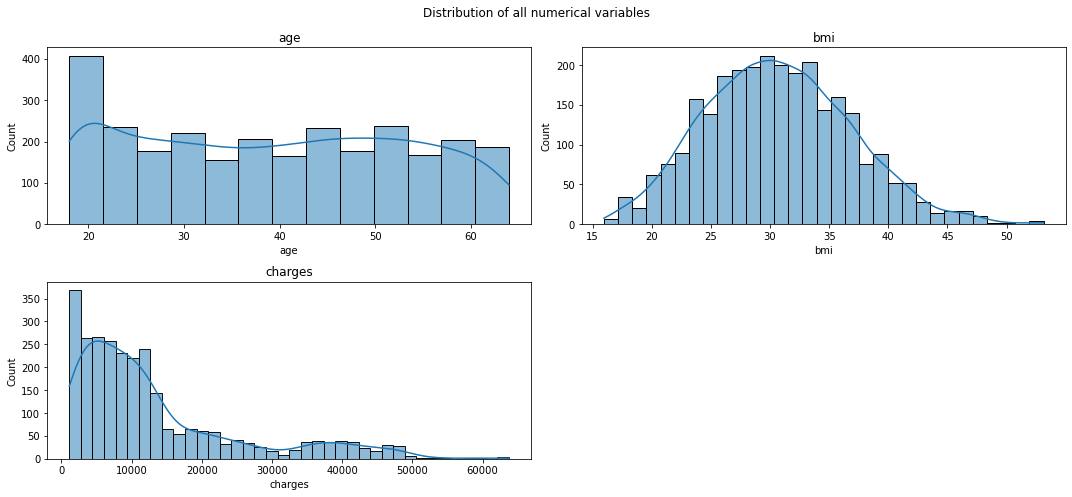

In [10]:
# density plot for all numeric variables

plt.figure(1, figsize=(15,7))
n_col = 2
n_row = int(np.ceil(len(num_cols)/2))
print(n_row, n_col)
for i,col in enumerate(num_cols):
    # print(col)
    plt.subplot(n_row, n_col, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    # plt.title(col)
plt.suptitle('Distribution of all numerical variables')  
plt.tight_layout()  
plt.show()

Observations:
1. Age: The age variable is almost uniformly distributed, which indicates that we have a relatively equal number of observations in each age group. This means that our sample is representative of the population in terms of age distribution.

2. BMI: The BMI variable is approximately normally distributed with a slight positive skew. This means that the majority of observations are close to the mean, but there are a few outliers on the higher end of the distribution. This suggests that there may be a small number of individuals with significantly higher BMIs than the rest of the population.

3. Charges: The charges variable is log-normally distributed. This means that the distribution is skewed to the right, with a large number of observations with low charges and a smaller number of observations with high charges. This is a common distribution for financial data, as it reflects the fact that there are typically many more small transactions than large transactions.

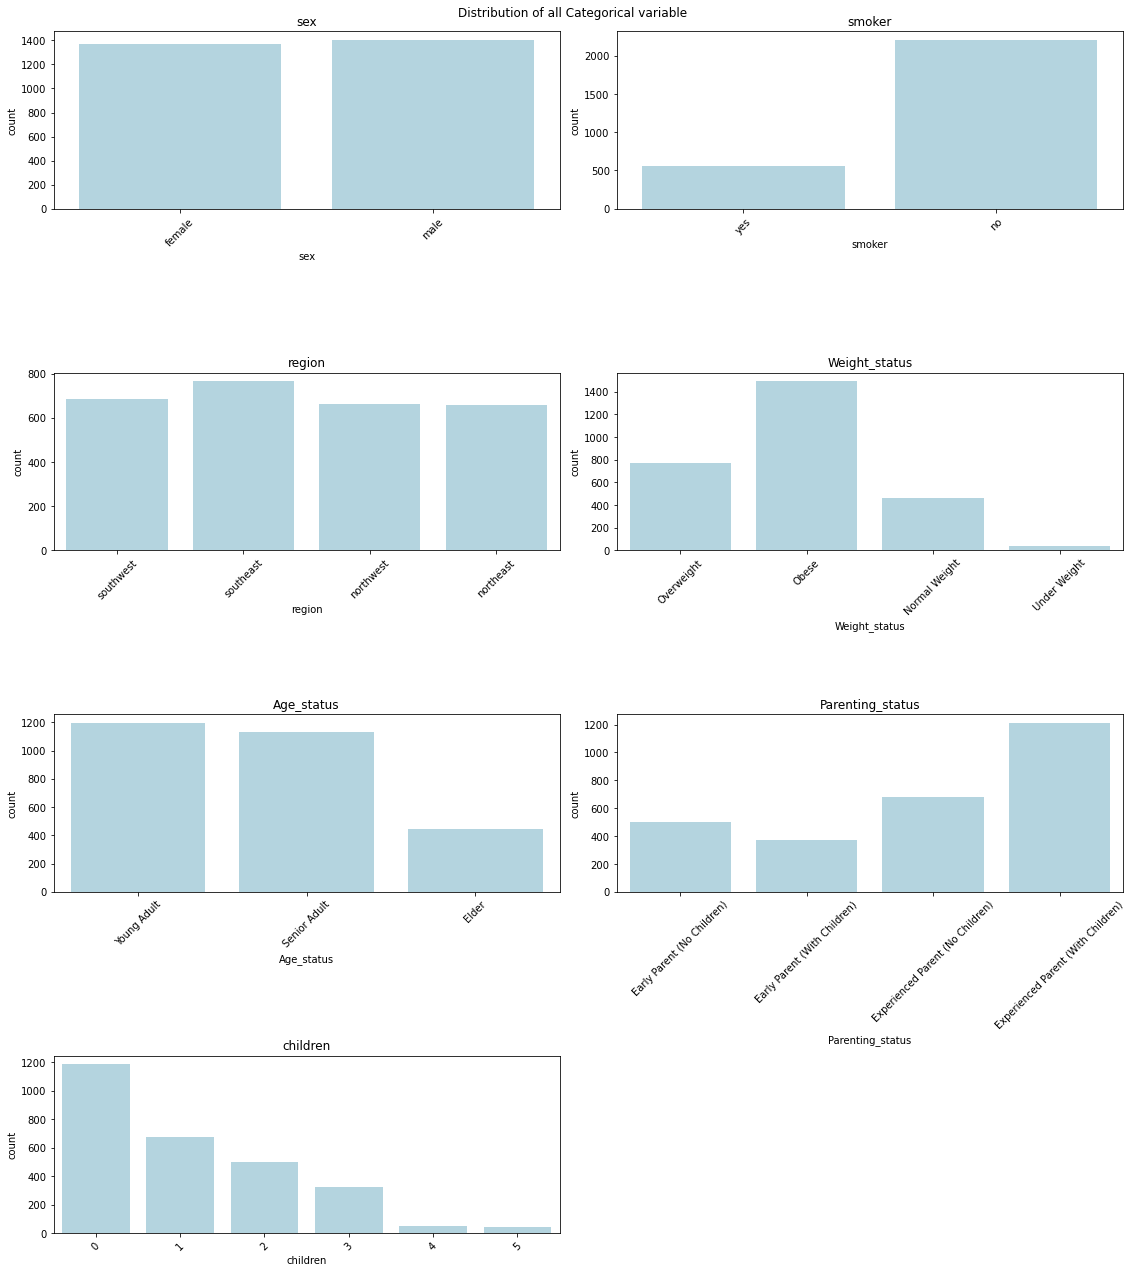

In [11]:
# count plot for all cat variables

plt.figure(1, figsize=(16,18))
n_col = 2
n_row = int(np.ceil(len(cat_cols)/2))
# print(n_row, n_col)
for i,col in enumerate(cat_cols):
    # print(col)
    plt.subplot(n_row, n_col, i+1)
    sns.countplot(data=df, x=col, color='lightblue')
    plt.title(col)
    plt.xticks(rotation=45)
plt.suptitle('Distribution of all Categorical variable')
plt.tight_layout()
plt.show()

#### Key Observations:

1. **Distribution Balance:**
   - With the exception of variables such as smoker, weight status, age status, and children, the remaining distributions exhibit a state of equilibrium or near equilibrium.

2. **Prevalence of Non-Smokers:**
   - The dataset comprises a notably larger number of observations for non-smokers, indicating a higher representation of this subgroup in the data.

3. **Weight Status Disparities:**
   - The population of underweight individuals is notably smaller compared to other weight categories, while observations for obese individuals are more abundant.

4. **Age Status Disproportion:**
   - Within the age status variable, the elder population is comparatively lower in number when juxtaposed with young adults or senior adults.

4. **Parenting Status Disproportion:**
   - We observe that experienced parents are more than the early parent category, and in both the category the norm follows that the people below 30 with no childeren are in majority and people above 30 we have majority with children as compared to people with no children.

5. **Children Distribution Characteristics:**
   - The distribution of children follows a pattern akin to a log-normal distribution, displaying right skewness. As the number of children increases, the corresponding observations exhibit a discernible decrease.

### 1.2 Bivariate Analysis

In [ ]:
# we will explore every other variable with charges.

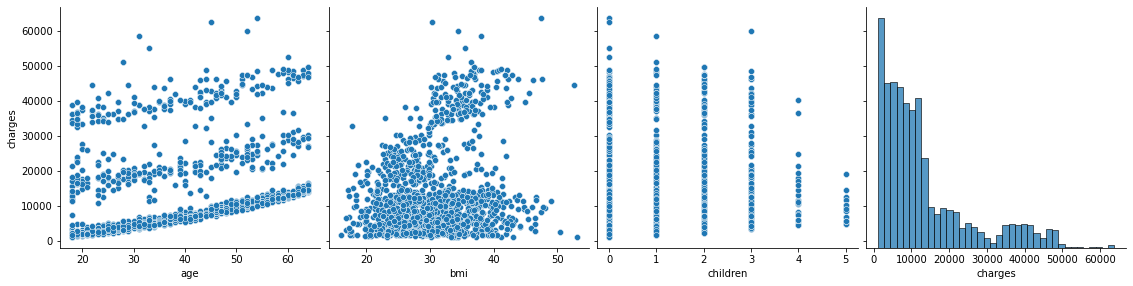

In [12]:
# lets study the how each numeric variables is related to charges using scatter plot
sns.pairplot(df,y_vars=['charges'], height=4)
plt.show()

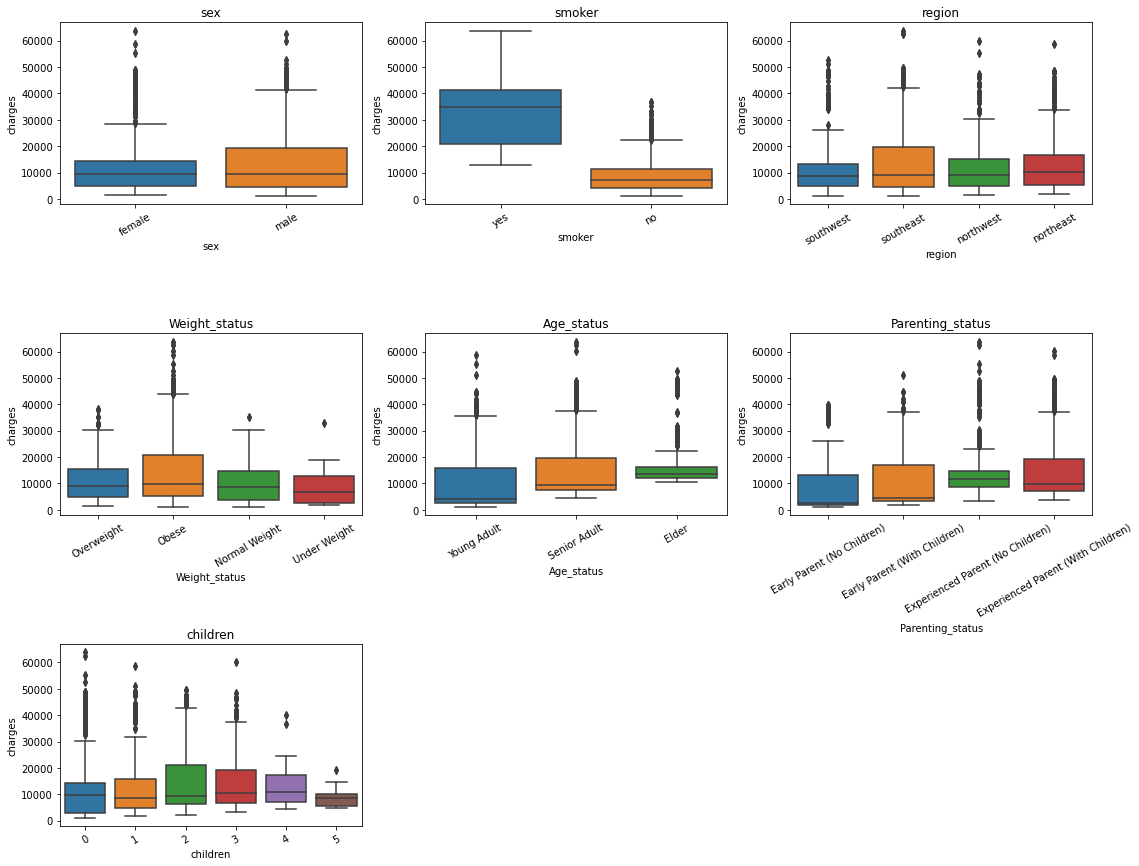

In [13]:
# box plot of all the categorical variables with respect to charges

plt.figure(1, figsize=(16,16))
n_col = 3
n_row = int(np.ceil(len(cat_cols)/2))
# print(n_row, n_col)
for i,col in enumerate(cat_cols):
    # print(col)
    plt.subplot(n_row, n_col, i+1)
    sns.boxplot(data=df, x=col, y='charges')
    plt.title(col)
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### Key Observations

1. **Gender Impact on Charges:**
   - The median charges for both males and females are observed to be equal, suggesting no significant disparity based on gender.

2. **Smoking Habits Influence:**
   - The most pronounced divergence is observed in the smoker variable, revealing substantially higher charges for smokers compared to non-smokers.

3. **Regional Disparities:**
   - Analysis of the 'region' variable indicates no substantial variance in median charges. This warrants further investigation to explore potential underlying factors.

4. **Weight Status and Medical Costs:**
   - Individuals classified as obese exhibit elevated medical costs, suggesting a correlation between weight status and incurred charges.

5. **Age as a Contributing Factor:**
   - Elderly individuals demonstrate a higher median in charges, with the interquartile range (IQR) concentrated towards the upper end. This underscores the impact of age on medical expenses.

6. **Parental Status Impact:**
   - Notably, individuals without children exhibit a higher median in charges compared to those with children. This highlights a potential association between parental status and medical expenditure, as observed by the number of children feature. But the parenting staus feature shows that experienced parents with no children exhibits a higher median chages.


### 1.3 Multivariate Analysis

Plotting every numberical features, with charges seperated by various categorical features
Seperation by sex:


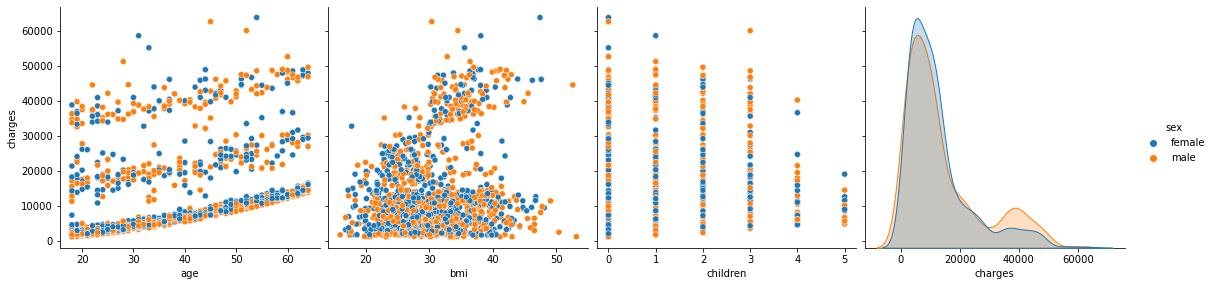

Seperation by smoker:


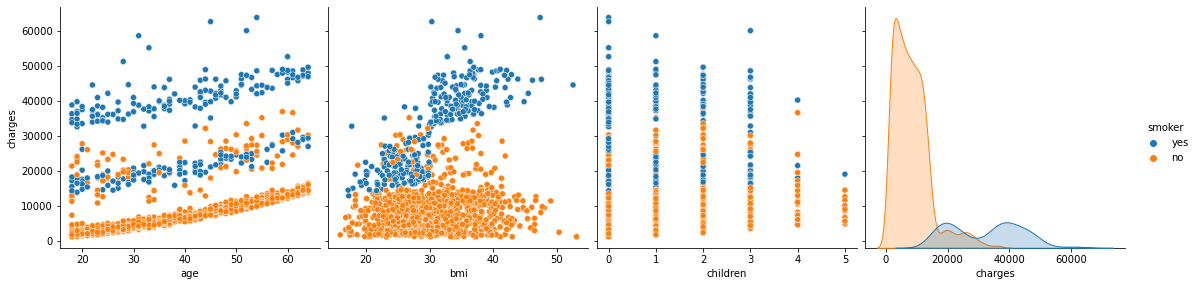

Seperation by region:


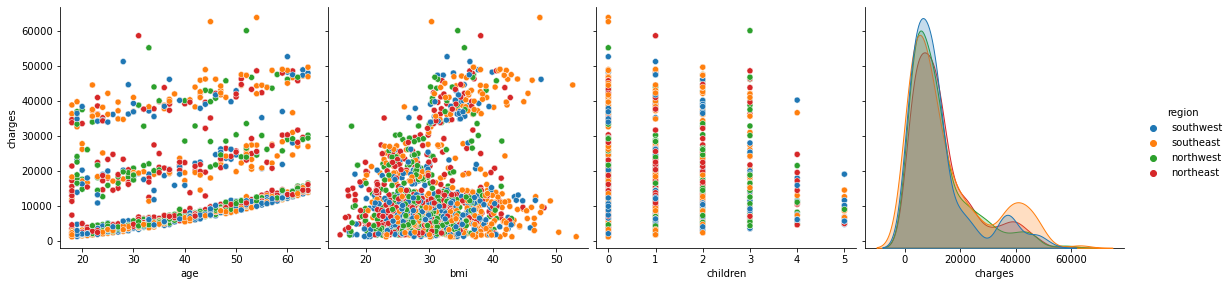

Seperation by Weight_status:


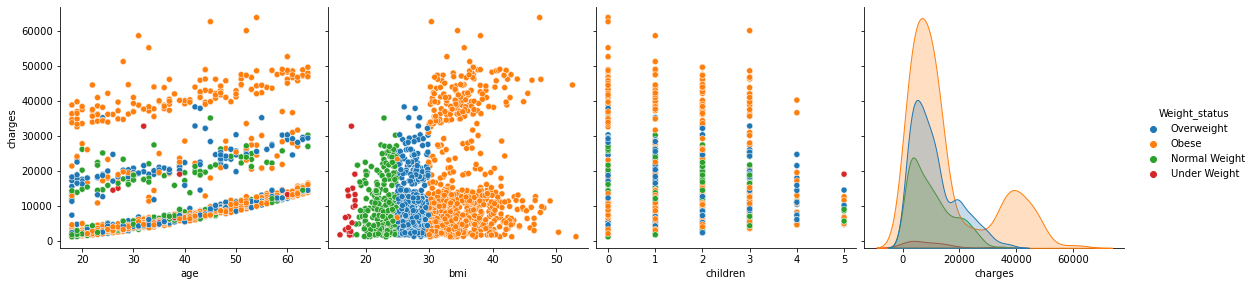

Seperation by Age_status:


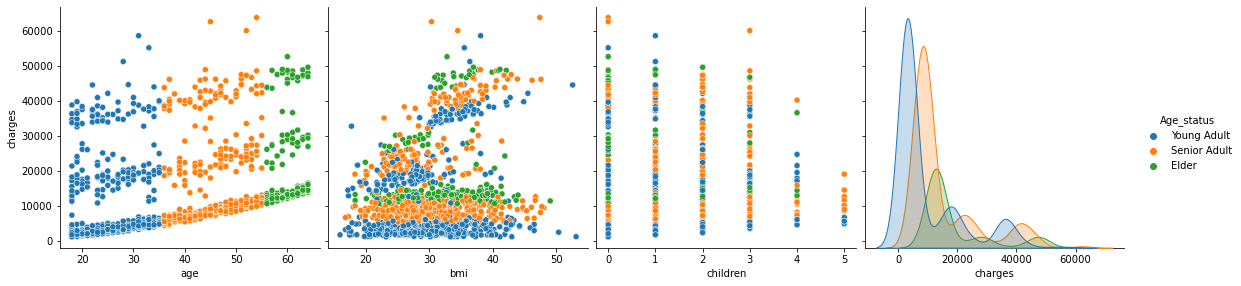

Seperation by Parenting_status:


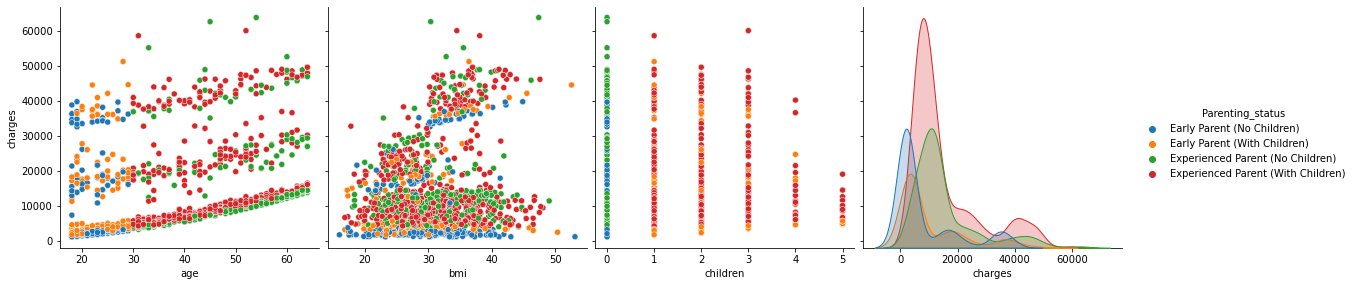

In [14]:
# this could be included in multivariate.
print('Plotting every numberical features, with charges seperated by various categorical features')

for col in cat_cols[:-1]:
    print('Seperation by {}:'.format(col))
    sns.pairplot(df,y_vars=['charges'],hue=col, height=4)
    plt.show()

#### Key Observations:

1. **Discernible Group Separations:**
   - The graphical representations highlight that variables such as smoker, weight status, and age status are the sole contributors to meaningful group differentiations concerning charges.

2. **BMI-Charges Relationship Insight:**
   - The scatter plot featuring BMI and charges reveals a distinct cluster at the upper end, indicating a subgroup characterized by individuals who are both smokers and obese. To gain a more detailed understanding of this specific group, a similar graph will be generated for individuals classified as obese and smokers.

These observations underscore the importance of smoker, weight status, and age status variables in influencing the distribution of charges. Further exploration, particularly focusing on the intersection of smoking and obesity is required.

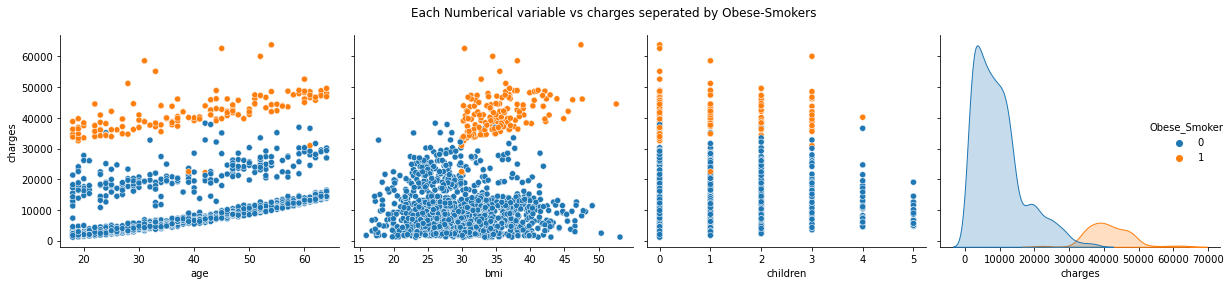

In [7]:
# lets take a closer look at obese smokers

df['Obese_Smoker'] = np.zeros(df.shape[0]).astype(int)
df.loc[(df['smoker'] == 'yes') & (df['Weight_status'] == 'Obese'), 'Obese_Smoker'] = 1

sns.pairplot(df,y_vars=['charges'], height=4, hue='Obese_Smoker')
plt.suptitle('Each Numberical variable vs charges seperated by Obese-Smokers')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Obese_Smoker')

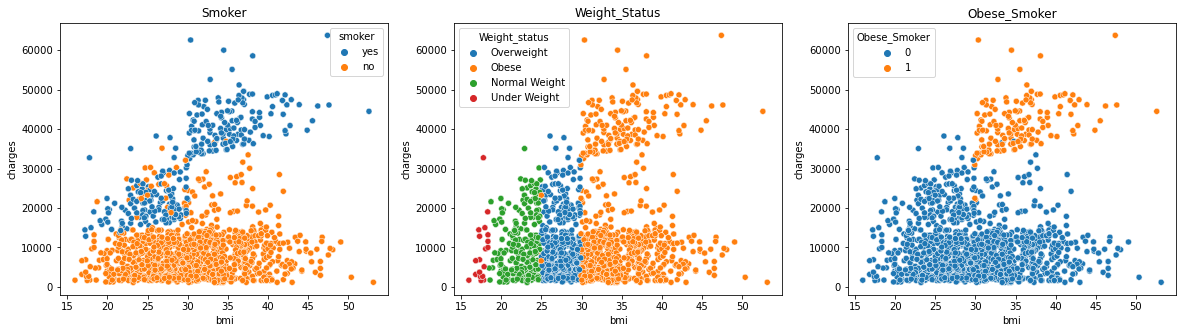

In [8]:
# the following plot shows the same behavior

plt.figure(1, figsize=(20,5))

plt.subplot(1,3,1)
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')
plt.title('Smoker')

plt.subplot(1,3,2)
sns.scatterplot(data=df, x='bmi', y='charges', hue='Weight_status')
plt.title('Weight_Status')

plt.subplot(1,3,3)
sns.scatterplot(data=df, x='bmi', y='charges', hue='Obese_Smoker')
plt.title('Obese_Smoker')

#### Noteworthy Finding:
In each of the above scatter plots, a conspicuous trend emerges where individuals classified as both obese and smokers exhibit the highest charges. This particular subgroup demonstrates a discernible separation from the remaining observations, underscoring the significance of the intersection between obesity and smoking in influencing medical charges. The clear distinction of this group emphasizes its potential impact on overall charge dynamics and warrants further investigation for a comprehensive understanding of contributing factors.

Text(0.5, 1.0, 'Age vs Charges Seperated by smoker')

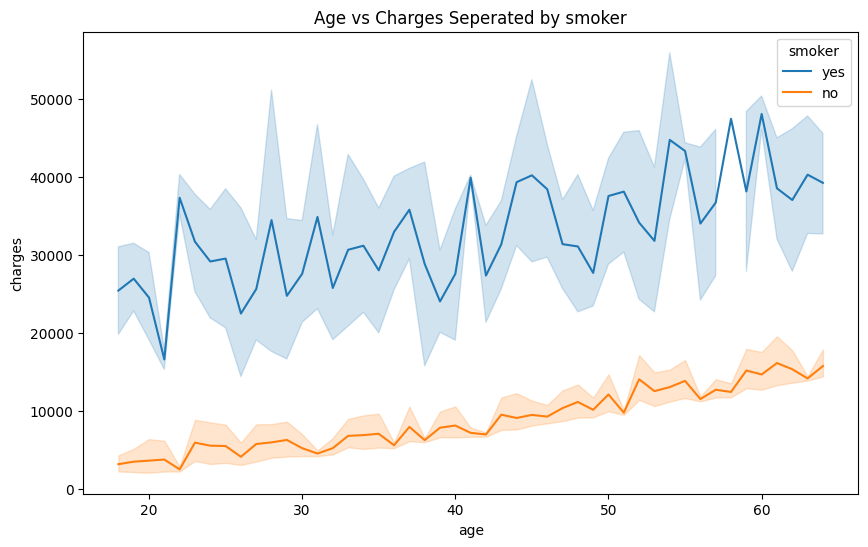

In [61]:
# let's try answering how age and smoking effects charges.

plt.figure(figsize=(10,6))
sns.lineplot(x='age',y='charges',hue='smoker',data=df)
plt.title('Age vs Charges Seperated by smoker')

#### Key Observation:

1. Regarding the age variable, analysis of the presented line graph reveals a notable trend wherein the group characterized by smoking habits incurs elevated charges. This observation underscores a potential correlation between smoking and increased medical charges within distinct age groups. Further exploration and statistical analysis may provide deeper insights into the nuanced relationship between age, smoking, and associated healthcare costs.

## 2. Focused Analysis to determine the factors which are affecting charges.

In [9]:
# defining helper function for outlier treatment

# outlier termination using IQR method 

def outlier_treatment_iqr(df):
    data = df.copy()
    q1 = data['charges'].quantile(0.25)
    q3 = data['charges'].quantile(0.75)

    iqr = q3 - q1

    lower_wisker = q1 - 1.5*iqr
    upper_wisker = q3 + 1.5*iqr

    treated_data = data[(data['charges'] <= upper_wisker) & (data['charges'] >= lower_wisker)]
    outlier_data = data[(data['charges'] > upper_wisker) | (data['charges'] < lower_wisker)]
    
    return (treated_data, outlier_data)


We will introduce a new column named ln_charges, which will contain the natural logarithm of the charges variable. This transformation is necessary because the charges variable exhibits a log-normal distribution, as demonstrated in our previous analysis. To conduct our intended hypothesis test, we require a normal distribution for the involved variable. Therefore, transforming the charges variable to its natural logarithm ensures the normality of its distribution, fulfilling the prerequisite for our hypothesis testing procedure.

We can also use box-cox transform but given the population of charges follows log nornal distribution, we can go ahead with log of charges.

In [10]:
df['ln_charges'] = np.log(df['charges'])

### 2.1 How smoking effects the individuals medial cost billed by the health insurance –

**Description:**
In this study, we aim to investigate the influence of smoking status on the medical costs incurred by individuals and subsequently billed by their health insurance. Our primary objective is to discern whether a significant relationship exists between an individual's smoking habits and the 
magnitude of medical expenses covered by health insurance.

**Reason:**
Understanding the impact of smoking on medical costs is essential for both healthcare providers and insurers. This analysis seeks to understand whether smokers tend to incur higher medical expenses, which can inform policy decisions, risk assessment, and public health strategies.

**Approach:**
1. Descriptive Analysis
2. Hypothesis testing
3. Regression Analysis


#### 2.1.1 Descriptive Analysis

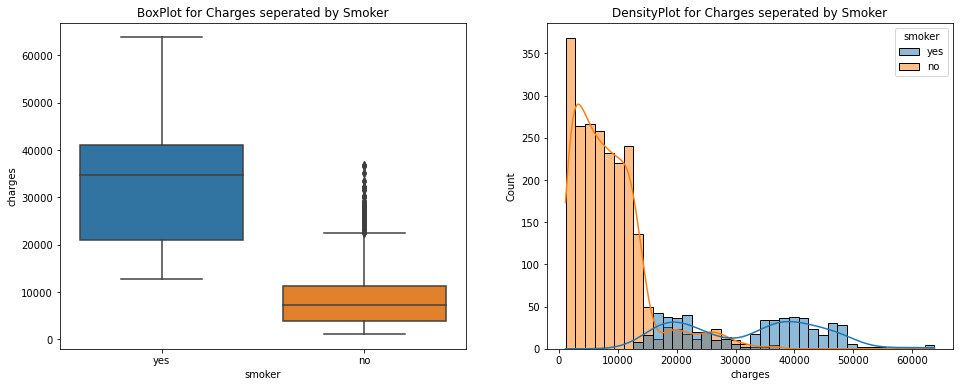

In [11]:
# let's first look at how smokers vs non smokers are effecting charges
plt.figure(1, figsize=(16,6))

plt.subplot(1,2,1)
sns.boxplot(data=df, x='smoker', y='charges')
plt.title('BoxPlot for Charges seperated by Smoker')

plt.subplot(1,2,2)
sns.histplot(data=df, x='charges', hue='smoker', kde=True)
plt.title('DensityPlot for Charges seperated by Smoker')

plt.show()

Observations:
1. The median charge for smokers is higher than the median charge for nonsmokers, and the IQR for smokers is also wider. This suggests that smokers have a wider range of charges than nonsmokers, with some smokers having very high charges.

2. The box plot shows that there are a few outliers in both the smoker and nonsmoker groups. These outliers are likely individuals with very high medical insurance charges, perhaps due to a serious medical condition or a major accident.

3. The density plot shows the distribution of charges for smokers and nonsmokers in more detail. The plot shows that the distribution of charges for smokers is skewed to the right, with a longer tail at the high end. This means that there are more smokers with very high charges than nonsmokers with very high charges.

4. Overall, the box plot and density plot suggest that smokers tend to have higher medical insurance charges than nonsmokers. 

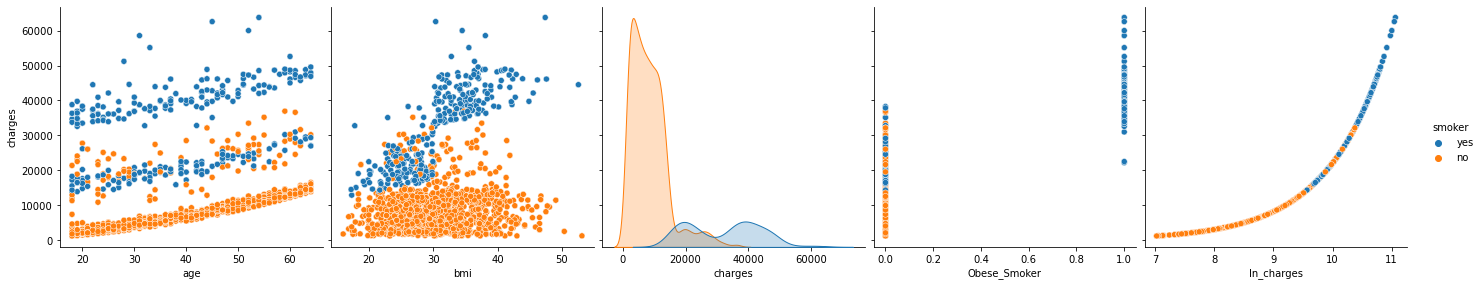

In [12]:
# Comparing each numeric variable seperated by smoker
sns.pairplot(df.drop('children', axis=1), y_vars=['charges'],hue='smoker', height=4)
plt.show()

Observations:

1. Age: Age is an interesting variable as we can see 3 groups if we look at it as a regression algorithm, let's label these groups in three categories, the first one being just smokers, the second one being a combination of smokers and non smokers and the third one is purely smokers. Each category shows a linear trend, so as the age increases the charges increases as well. The first group(non smokers) incur the lowest charges, the second group(combination of smoker and non smoker) has the second highest chaeges and lastly the third group(only smokers) incur the highest charges.
2. If there is a use case where an insurance company thinks that a person has lied in their application stating they do not smoke, but are still incuring high chaeges we can use the data to predict if the person is a smoker or not.
3. BMI: as BMI increases we expect that the charges will increase and that is the trend we observe with the above graph. The interesting thing in the graph is that we can see taht the smokers do incur a higher value for charges as we do expect.

#### 2.1.2 Hypothesis Testing: Smoking impacts the medical charges

H0: The charges for individuals who smoke is either equal to or lower than that of non-smokers.

H1: The charges for individuals who smoke is more than that of non-smokers.

significance level (alpha): 0.05 or 5%

We will go ahead with a one tailed T-test as it represents real world process better.

Outliers will be treated using the IQR method

Assumptions of t-test:
1. Both the groups should have same No of Datapoints 
2. Both the groups should follow Normal Distributed  
3. Both the groups should have Similar Variance

if we have more datapoints in one group we can downsample the larges group, and if the normality and variance assumption is not perfectly met, we can still proceed with the test as we have a large sample size.

Shape of both the group before downsampling
Smokers (564, 12)
Non-Smokers (2112, 12)


Shape of both the group after downsampling
Smokers (564, 12)
Non-Smokers (564, 12)


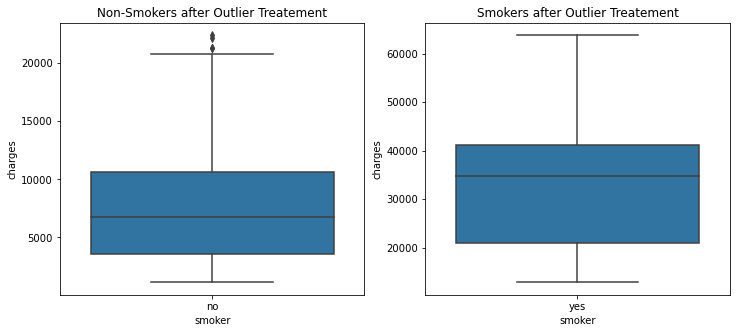

In [13]:
# 1. Assumption check - Both the groups should have same No of Datapoints and taking care of outliers

# let's create two groups, smokers and non-smokers
# we will create a new column named ln_charges, which will be the log of charges.

smokers_df = df[df['smoker'] == 'yes']
non_smokers_df = df[df['smoker'] == 'no']

# From the above descriptive analysis we can see that we have a lot of outliers for non smokers
smokers_df, outliers_smokers_df = outlier_treatment_iqr(smokers_df)
non_smokers_df, outliers_non_smokers_df = outlier_treatment_iqr(non_smokers_df)

# let's check the shape of both the groups
print('Shape of both the group before downsampling')
print('Smokers', smokers_df.shape)
print('Non-Smokers', non_smokers_df.shape)
print('\n')

# downsample the non_smoker group as we have a lot more observations in non_smoker group 
non_smokers_df = non_smokers_df.sample(n=smokers_df.shape[0] , replace=False)
print('Shape of both the group after downsampling')

# shape of groups after downsampling
print('Smokers', smokers_df.shape)
print('Non-Smokers', non_smokers_df.shape)

# plotting to see the effect of outlier treatement
plt.figure(1, figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=non_smokers_df, x='smoker', y='charges')
plt.title('Non-Smokers after Outlier Treatement')
plt.subplot(1,2,2)
sns.boxplot(data=smokers_df, x='smoker', y='charges')
plt.title('Smokers after Outlier Treatement')

plt.show()

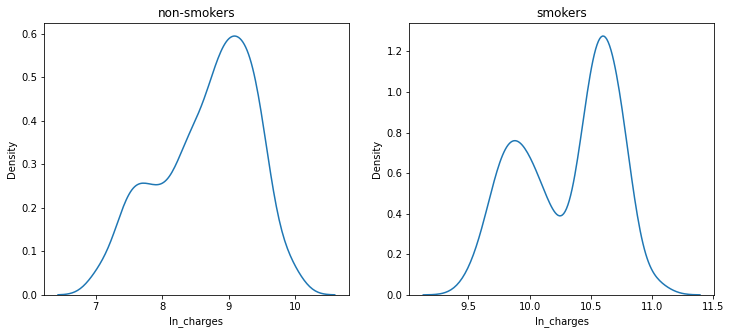

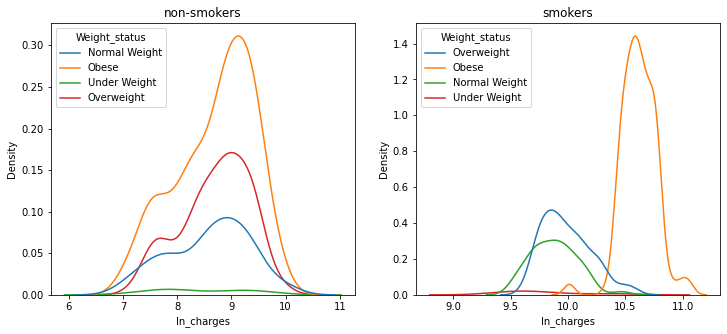

In [22]:
# 2. Assumption check - Both the groups should follow Normal Distributed
# investigating using kde plot

plt.figure(1, figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=non_smokers_df, x='ln_charges')
plt.title('non-smokers')

plt.subplot(1,2,2)
sns.kdeplot(data=smokers_df, x='ln_charges')
plt.title('smokers')

plt.figure(2, figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=non_smokers_df, x='ln_charges', hue='Weight_status')
plt.title('non-smokers')

plt.subplot(1,2,2)
sns.kdeplot(data=smokers_df, x='ln_charges', hue='Weight_status')
plt.title('smokers')
plt.show()

While the overall distribution of smokers does not exhibit perfect normality according to the above graphs, further analysis reveals a more nuanced picture. When we stratify the data by weight status, we observe that each individual weight group within the smoker population adheres to a normal distribution. Furthermore, the obese smoker group exhibits a significant separation from the other weight categories, indicating a distinct distribution pattern. We will further investigate the normality assumption using qq-plot.

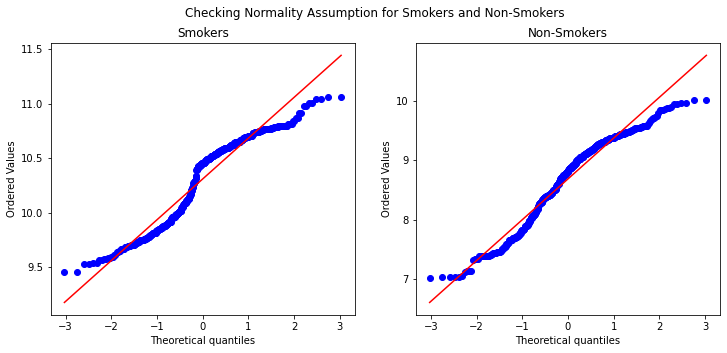

In [14]:
# 2. Assumption check - Both the groups should follow Normal Distributed
# we will perform this using qq plot

# checking for 
plt.figure(1, figsize=(12,5))
plt.subplot(1,2,1)
stats.probplot(smokers_df['ln_charges'], dist="norm", plot=plt)
plt.title('Smokers')

plt.subplot(1,2,2)
stats.probplot(non_smokers_df['ln_charges'], dist="norm", plot=plt)
plt.title('Non-Smokers')

plt.suptitle('Checking Normality Assumption for Smokers and Non-Smokers')
plt.show()

Visual inspection of the data distributions reveals that they are approximate normal distributions sufficiently. This satisfies the normality assumption required for conducting a t-test, allowing us to proceed with the analysis.

In [24]:
# performing the t-test

t_stat, p_val = stats.ttest_ind(smokers_df['ln_charges'], non_smokers_df['ln_charges'], equal_var=False)
print('T-Statistic:', t_stat)
print('P-value:', p_val/2)

T-Statistic: 48.559429312157434
P-value: 2.395245994247567e-251


Null Hypothesis (H0): The charges for individuals who smoke are equal to or lower than that of non-smokers.

Alternative Hypothesis (H1): The charges for individuals who smoke are higher than that of non-smokers.

Significance Level (α): 0.05 or 5%



Analysis:

The calculated T-statistic of 32.8979 is very large, indicating a strong deviation from the null hypothesis. Additionally, the P-value of 8.489291901363343e-120 is practically zero, meaning the probability of observing such a large T-statistic by chance alone is extremely low.

Since the P-value is less than the chosen significance level (α = 0.05), we reject the null hypothesis (H0) and accept the alternative hypothesis (H1).

Conclusion:

The analysis provides strong evidence that the average medical charges for individuals who smoke are significantly higher than those for non-smokers. This result supports the claim that smoking incurs greater healthcare costs.

#### 2.1.3 Regression Analysis: Exploring the Impact of Smoking on Medical Charges

This section delves deeper into the relationship between smoking and medical charges, utilizing a regression analysis framework.

**Purpose:**

The primary objective of this analysis is to quantify the impact of smoking status on medical charges, measured as the natural logarithm of charges (ln_charges). Additionally, it aims to assess the potential interaction effect between smoking and age, as suggested by the observed divergent trends in the age-charge scatter plot for smokers and non-smokers.



**Model Specification:**

ln_charges = β₁ * age + β₂ * bmi + β₃ * smoker + β₄ * (age * smoker) + ε


**Rationale for Model Specification:**

Age: Age is included as an independent variable due to its well-established association with healthcare utilization and costs.

BMI: BMI is included to account for the potential confounding effect of body weight on medical charges.

Smoker: The smoker variable is the primary variable of interest, allowing us to quantify the independent effect of smoking status on medical charges.

Interaction Term: The interaction term (age * smoker) allows the model to estimate separate slopes for the relationship between age and ln_charges for smokers and non-smokers. This addresses the potential for a differential effect of age on medical charges based on smoking status.


In [15]:
x = df[['age', 'bmi', 'smoker']].copy()
y = df['ln_charges'].copy()

x['smoker'] = x['smoker'].map({'no': 0, 'yes': 1})
x['smoker_age'] = x['smoker'] * x['age']


#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_charges   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     2429.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:35:45   Log-Likelihood:                -1625.9
No. Observations:                2772   AIC:                             3262.
Df Residuals:                    2767   BIC:                             3291.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8716      0.047    144.709      0.0

**Overall Model Fit:**

1. The model has a high R-squared value of 0.778, indicating that it explains a significant portion (77.8%) of the variance in ln_charges.
2. The F-statistic is highly significant (p-value < 0.001), further supporting the overall model fit.


**Individual Variable Effects:**

age (β₁ = 0.0415): A one-unit increase in age is associated with an average increase of 0.0415 units in ln_charges, holding other variables constant. This suggests a positive and statistically significant relationship between age and medical charges.

bmi (β₂ = 0.0101): A one-unit increase in BMI is associated with an average increase of 0.0101 units in ln_charges, holding other variables constant. This indicates a positive and statistically significant relationship between BMI and medical charges.

smoker (β₃ = 2.7605): Smokers incur significantly higher medical charges compared to non-smokers, holding other variables constant. The coefficient value of 2.7605 indicates that smokers have an average ln_charges value 2.7605 units higher than non-smokers.

smoker_age (β₄ = -0.0314): This interaction term captures the differential effect of age on ln_charges for smokers and non-smokers. The negative coefficient suggests that the slope of the age-ln_charges relationship is steeper for non-smokers compared to smokers. This indicates that medical charges increase at a faster rate with age for non-smokers than for smokers.

**Conclusion:**

The regression analysis provides robust evidence that smoking status, age, and BMI are significant predictors of medical charges. Smokers, on average, incur substantially higher medical charges compared to non-smokers, even after accounting for the influence of age and BMI. Additionally, the interaction term reveals that the relationship between age and medical charges differs for smokers and non-smokers. This suggests that public health interventions targeting smoking cessation and age-related healthcare needs may be crucial in reducing the overall burden of medical costs.

### 2.2 How Obesity or Weight Status effects the individuals medial cost billed by the health insurance –

**Description:**
In this study, we aim to investigate the influence of obisity on the medical costs incurred by individuals and subsequently billed by their health insurance. Our primary objective is to discern whether a significant relationship exists between obesity and the 
magnitude of medical expenses covered by health insurance.

**Reason:**
Understanding how obesity affects medical costs is important for healthcare professionals, insurers, and policymakers. This study is important to understanding whether obesity is linked to higher medical costs. This information can be used to make decisions about healthcare policy, 
assess risk, and develop targeted interventions.

**Approach:**
1. Hypothesis testing
2. Regression Analysis


#### 2.2.1 Hypothesis Testing: Obesity impacts the medical charges

H0: The charges for individuals who are obese is either equal to or lower than that of non-obese.

H1: The charges for individuals who are obese is more than that of non-obese.

significance level (alpha): 0.05 or 5%

We will go ahead with a one tailed T-test as it represents real world process better.

Outliers will be treated using the IQR method

Assumptions of t-test:
1. Both the groups should have same No of Datapoints 
2. Both the groups should follow Normal Distributed  
3. Both the groups should have Similar Variance

if we have more datapoints in one group we can downsample the larges group, and if the normality and variance assumption is not perfectly met, we can still proceed with the test as we have a large sample size.

Shape of both the group before downsampling
Obese (1396, 12)
Non-Obese (1252, 12)


Shape of both the group after downsampling
Smokers (1252, 12)
Non-Smokers (1252, 12)


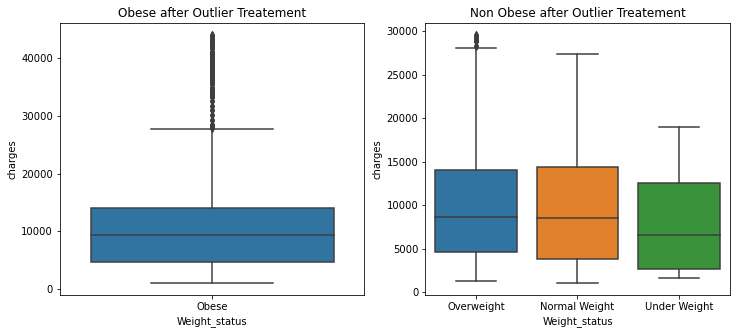

In [16]:
# 1. Assumption check - Both the groups should have same No of Datapoints and taking care of outliers

# let's create two groups, obese and non-obese
obese_df = df[df['Weight_status'] == 'Obese']
non_obese_df = df[df['Weight_status'] != 'Obese']

# From the above descriptive analysis we can see that we have a lot of outliers for obese
obese_df, outliers_obese_df = outlier_treatment_iqr(obese_df)
non_obese_df, outliers_non_obese_df = outlier_treatment_iqr(non_obese_df)

# let's check the shape of both the groups
print('Shape of both the group before downsampling')
print('Obese', obese_df.shape)
print('Non-Obese', non_obese_df.shape)
print('\n')

# downsample the non_smoker group as we have a lot more observations in non_smoker group 
obese_df = obese_df.sample(n=non_obese_df.shape[0] , replace=False)
print('Shape of both the group after downsampling')

# shape of groups after downsampling
print('Smokers', obese_df.shape)
print('Non-Smokers', non_obese_df.shape)

# plotting to see the effect of outlier treatement
plt.figure(1, figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=obese_df, x='Weight_status', y='charges')
plt.title('Obese after Outlier Treatement')
plt.subplot(1,2,2)
sns.boxplot(data=non_obese_df, x='Weight_status', y='charges')
plt.title('Non Obese after Outlier Treatement')

plt.show()

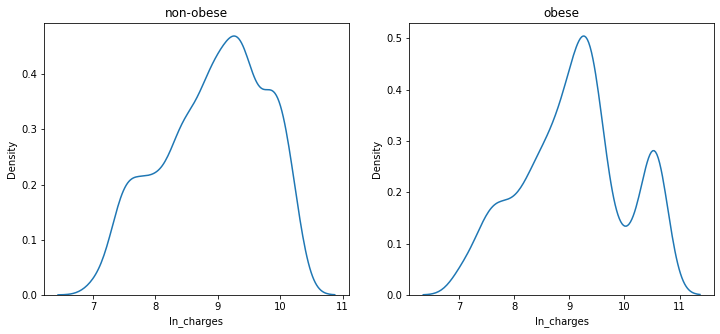

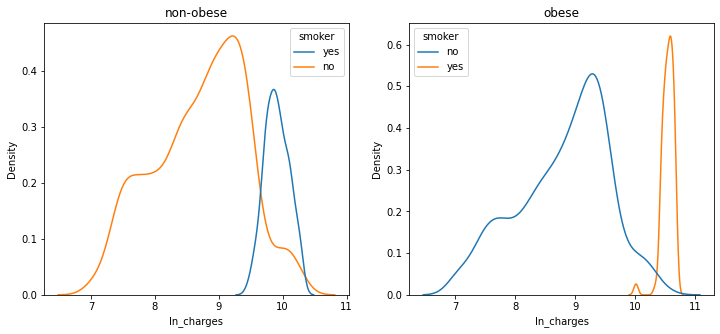

In [26]:
# 2. Assumption check - Both the groups should follow Normal Distributed
# investigating using kde plot

plt.figure(1, figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=non_obese_df, x='ln_charges')
plt.title('non-obese')

plt.subplot(1,2,2)
sns.kdeplot(data=obese_df, x='ln_charges')
plt.title('obese')

plt.figure(2, figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=non_obese_df, x='ln_charges', hue='smoker')
plt.title('non-obese')

plt.subplot(1,2,2)
sns.kdeplot(data=obese_df, x='ln_charges', hue='smoker')
plt.title('obese')
plt.show()

While the overall distribution of obese does not exhibit perfect normality according to the above graphs, further analysis reveals a more nuanced picture. When we stratify the data by smoker, we observe that each individual group within the obese population adheres to a normal distribution. Furthermore, the obese smoker group exhibits a significant separation from obese non-smoker, indicating a distinct distribution pattern. We will further investigate the normality assumption using qq-plot.

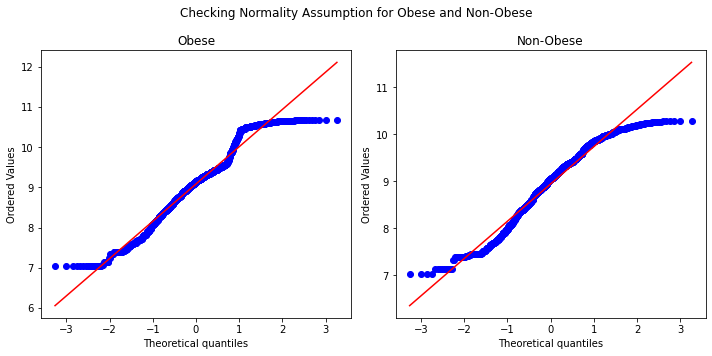

In [27]:
# 2. Assumption check - Both the groups should follow Normal Distributed
# we will perform this using qq plot

# checking for 
plt.figure(1, figsize=(10,5))
plt.subplot(1,2,1)
stats.probplot(obese_df['ln_charges'], dist="norm", plot=plt)
plt.title('Obese')

plt.subplot(1,2,2)
stats.probplot(non_obese_df['ln_charges'], dist="norm", plot=plt)
plt.title('Non-Obese')
plt.suptitle('Checking Normality Assumption for Obese and Non-Obese')
plt.tight_layout()
plt.show()

Visual inspection of the data distributions reveals that they are approximate normal distributions sufficiently. This satisfies the normality assumption required for conducting a t-test, allowing us to proceed with the analysis.

In [28]:
# performing the t-test

t_stat, p_val = stats.ttest_ind(obese_df['ln_charges'], non_obese_df['ln_charges'], equal_var=False)
print('T-Statistic:', t_stat)
print('P-value:', p_val/2)

T-Statistic: 4.061085090106653
P-value: 2.519109701526585e-05


Null Hypothesis (H0): The charges for individuals who are obese are equal to or lower than that of non-obese.

Alternative Hypothesis (H1): The charges for individuals who are obese are higher than that of non-obese.

Significance Level (α): 0.05 or 5%



Analysis:

The calculated T-statistic of 4.061 indicates a large effect size, suggesting a significant difference in medical charges between obese and non-obese individuals. 

This finding is further supported by the extremely low P-value of 2.519109701526585e-05.

Since the P-value is less than the chosen significance level (α = 0.05), we reject the null hypothesis (H0) and accept the alternative hypothesis (H1).

Conclusion:

The analysis provides strong evidence that the average medical charges for individuals who obese are significantly higher than those for non-obese. This result supports the claim that obese individuals incurs greater healthcare costs.

#### 2.2.2 Regression Analysis: Exploring the Impact of Obesity on Medical Charges

This section delves deeper into the relationship between Obesity and medical charges, utilizing a regression analysis framework.

**Purpose:**

The primary objective of this analysis is to quantify the impact of Obesity status on medical charges, measured as the natural logarithm of charges (ln_charges). Additionally, it aims to assess the potential interaction effect between Obesity and age, as suggested by the observed divergent trends in the age-charge scatter plot for obese and non-obese.


**Model Specification:**

ln_charges = β₁ * age + β₂ * smoker + β₃ * obese + β₄ * (age * obese) + ε


**Rationale for Model Specification:**

Age: Age is included as an independent variable due to its well-established association with healthcare utilization and costs .

obese: The obese variable is the primary variable of interest, allowing us to quantify the independent effect of obesity status on medical charges.

Interaction Term: The interaction term (age * obese) allows the model to estimate separate slopes for the relationship between age and ln_charges for obese and non-obese. This addresses the potential for a differential effect of age on medical charges based on obesity status.


In [17]:
# lets create a feature called obese, indicating if a person is obese or not
# we will also create another column named age_obese = age * obese

df['Obese'] = df['Weight_status'].apply(lambda x: 1 if x=='Obese' else 0)
df['age_obese'] = df['age'] * df['Obese']
print(df.head(3))

   age     sex    bmi  children smoker     region     charges Weight_status  \
0   19  female  27.90         0    yes  southwest  16884.9240    Overweight   
1   18    male  33.77         1     no  southeast   1725.5523         Obese   
2   28    male  33.00         3     no  southeast   4449.4620         Obese   

    Age_status              Parenting_status  Obese_Smoker  ln_charges  Obese  \
0  Young Adult    Early Parent (No Children)             0    9.734176      0   
1  Young Adult  Early Parent (With Children)             0    7.453302      1   
2  Young Adult  Early Parent (With Children)             0    8.400538      1   

   age_obese  
0          0  
1         18  
2         28  


In [30]:
# defining our dependent and independent variables
x = df[['age', 'smoker','Obese', 'age_obese']].copy()
y = df['ln_charges'].copy()

x['smoker'] = x['smoker'].map({'no': 0, 'yes': 1})

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_charges   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     2003.
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:13:18   Log-Likelihood:                -1829.5
No. Observations:                2772   AIC:                             3669.
Df Residuals:                    2767   BIC:                             3699.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2631      0.039    186.415      0.0

**Individual Variable Effects:**

- **Age:** The coefficient for age is positive and highly statistically significant (p < 0.0001), indicating that there's a significant positive relationship between age and ln_charges. For every one-year increase in age, ln_charges increase by approximately 0.0370 units.

- **Smoker:** The coefficient for smoker is also positive and highly statistically significant (p < 0.0001), suggesting that smokers have significantly higher ln_charges compared to non-smokers. On average, smokers have ln_charges approximately 1.5533 units higher than non-smokers, holding other variables constant.

- **Obese:** The coefficient for obese is positive and statistically significant (p < 0.0001), indicating that obese individuals have higher ln_charges compared to non-obese individuals. The estimated effect size suggests that ln_charges are approximately 0.2471 units higher for obese individuals, holding other variables constant.

- **Interaction (age_obese):** The coefficient for the interaction term, age_obese, is negative and statistically significant (p = 0.019), suggesting a significant interaction effect between age and obesity on ln_charges. The interpretation of this coefficient indicates that the relationship between age and ln_charges differs between obese and non-obese individuals. Specifically, the effect of age on ln_charges is slightly attenuated for obese individuals compared to non-obese individuals.

**Conclusion:**

The regression results demonstrate the significant impact of age, smoking, and obesity on ln_charges. While both smoking and obesity are associated with higher ln_charges, age also plays a significant role. Additionally, the interaction between age and obesity highlights the nuanced relationship between these variables. Further investigation into the interaction effect and potential implications for healthcare policy and practice is warranted.



### 2.3 Predictive Modelling - Linear Regression to Predict Charges

Approach - 
1. Data Splitting:
   - Division of the dataset into training and testing sets to facilitate model evaluation.
   - Maintaining the integrity of the data distribution across the splits to ensure representative sampling.

2. Data Standardization:
   - Standardizing data to bring it on the same scale.
   

3. Modeling with Various Techniques:
   - Linear Regression: Utilizing traditional linear regression methods.
   - Regularized Regression (Ridge, Lasso): Implementing regularization techniques to prevent overfitting and improve model generalization.
   - Support Vector Regression (SVR): Employing SVR to capture nonlinear relationships between predictor variables and medical charges.
   - Decision Tree Regressor: Leveraging decision tree-based models to uncover complex interactions within the data.

4. Model Selection:
   - Evaluating the performance of each model using appropriate metrics such as mean squared error and mean absolute error.
   - Comparing the models' predictive capabilities and selecting the most suitable one for predicting medical charges accurately.

5. Feature Importance:
   - Analyzing the importance of different features in predicting medical charges.
   - Identifying key demographic and health-related factors that significantly influence healthcare expenses.


In [24]:
# standardizing and splitting the data

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# data partition 
# x = df.drop(['charges', 'ln_charges'], axis=1)
x = df.drop(['charges', 'ln_charges', 'Obese_Smoker', 'age_obese', 'Obese'], axis=1)
y = df['ln_charges']

# getting dummy variables
x = pd.get_dummies(x, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1940, 16) (1940,)
(832, 16) (832,)


In [19]:
df.drop(['charges', 'ln_charges', 'Obese_Smoker', 'age_obese'], axis=1).columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'Weight_status',
       'Age_status', 'Parenting_status', 'Obese'],
      dtype='object')

In [25]:
# defining our dependent and independent variables
x = X_train.copy()
y = y_train.copy()


#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_charges   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     433.9
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:39:34   Log-Likelihood:                -1084.4
No. Observations:                1940   AIC:                             2203.
Df Residuals:                    1923   BIC:                             2297.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

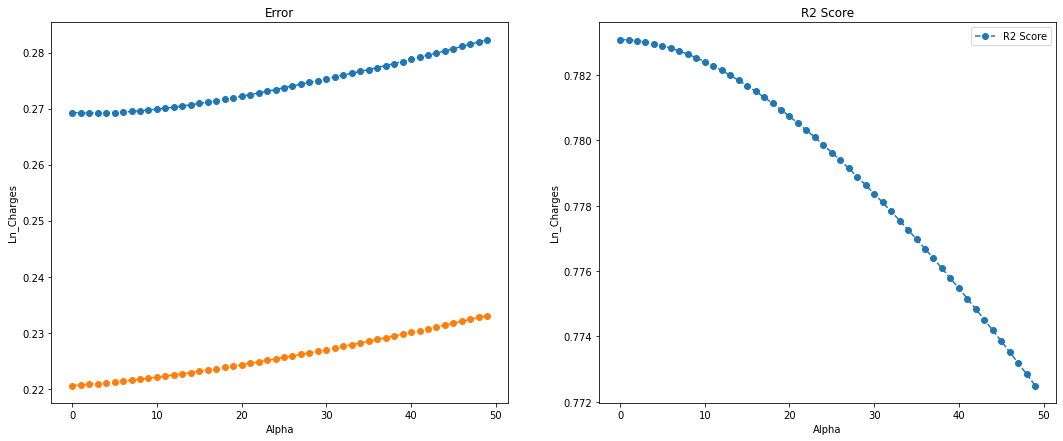

In [26]:
# ridge regression

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error


error_ridge = []
r2_list = []
alpha_upper_bound = 50
for a in range(0,alpha_upper_bound):
    regressor_ridge = Ridge(alpha=a)
    regressor_ridge.fit(X_train, y_train)

    y_pred_train = regressor_ridge.predict(X_train)
    y_pred_test = regressor_ridge.predict(X_test)

    error_ridge.append([mean_absolute_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)])
    r2_list.append(regressor_ridge.score(X_train, y_train))

error_ridge = np.array(error_ridge)    



plt.figure(figsize=(18,7))
plt.grid()

plt.subplot(1,2,1)
plt.title('Error')
plt.plot(list(range(0,alpha_upper_bound)), error_ridge[:,0], '--o', label='Train Error')
plt.plot(list(range(0,alpha_upper_bound)), error_ridge[:,1], '--o', label='Test Error')
plt.xlabel('Alpha')
plt.ylabel('Ln_Charges')

plt.subplot(1,2,2)
plt.title('R2 Score')
plt.plot(list(range(0,alpha_upper_bound)), r2_list, '--o', label='R2 Score')
plt.xlabel('Alpha')
plt.ylabel('Ln_Charges')

plt.legend()
plt.show()


In [27]:
# selecting the most balanced alpha 

best_alpha_ridge = np.absolute(error_ridge[:,0] - error_ridge[:, 1]).argmin()
print('Best Alpha Value:', best_alpha_ridge)
print('Train and Test error:', error_ridge[best_alpha_ridge])

Best Alpha Value: 13
Train and Test error: [0.27045484 0.22265717]


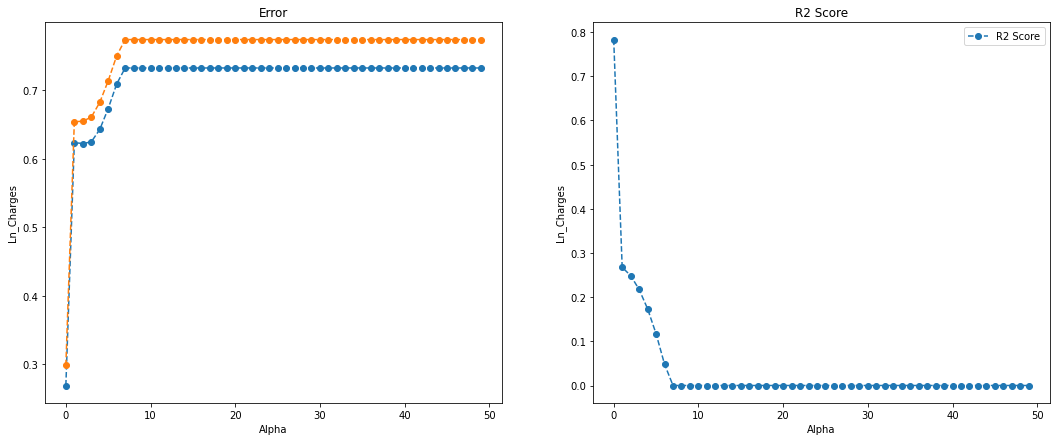

In [28]:
# lasso regression

error_lasso = []
r2_list = []
alpha_upper_bound = 50
for a in range(0,alpha_upper_bound):
    regressor_lasso = Lasso(alpha=a)
    regressor_lasso.fit(X_train, y_train)

    y_pred_train = regressor_lasso.predict(X_train)
    y_pred_test = regressor_lasso.predict(X_test)

    error_lasso.append([mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)])
    r2_list.append(regressor_lasso.score(X_train, y_train))
    
error_lasso = np.array(error_lasso)    



plt.figure(figsize=(18,7))
plt.grid()

plt.subplot(1,2,1)
plt.title('Error')
plt.plot(list(range(0,alpha_upper_bound)), error_lasso[:,0], '--o', label='Train Error')
plt.plot(list(range(0,alpha_upper_bound)), error_lasso[:,1], '--o', label='Test Error')
plt.xlabel('Alpha')
plt.ylabel('Ln_Charges')


plt.subplot(1,2,2)
plt.title('R2 Score')
plt.plot(list(range(0,alpha_upper_bound)), r2_list, '--o', label='R2 Score')
plt.xlabel('Alpha')
plt.ylabel('Ln_Charges')

plt.legend()
plt.show()

In [29]:
# selecting the most balanced alpha 

best_alpha_lasso = np.absolute(error_lasso[:,0] - error_lasso[:, 1]).argmin()
print('Best Alpha Value:', best_alpha_lasso)
print('Train and Test error:', error_lasso[best_alpha_lasso])

Best Alpha Value: 0
Train and Test error: [0.26927324 0.29887077]


The results suggest that for ridge regression, the best alpha value is 11, whereas for lasso regression, the best alpha value is 0. 

1. **Ridge Regression:**
   - Best Alpha Value: 11
   - Train Error: 0.27026594
   - Test Error: 0.22222946

2. **Lasso Regression:**
   - Best Alpha Value: 0
   - Train Error: 0.26927324
   - Test Error: 0.29887077

In ridge regression, a larger alpha value penalizes the coefficients more, which helps to reduce overfitting. The test error is lower than the train error, indicating good generalization to unseen data. 

In contrast, lasso regression with alpha 0 indicates no regularization, essentially fitting the data without any penalty for complexity. This might lead to overfitting, as evidenced by the higher test error compared to the train error.

Overall, while both models aim to reduce overfitting, ridge regression seems to provide better performance in this scenario, as it achieves a lower test error with regularization.

100%|██████████| 19/19 [19:18<00:00, 60.98s/it] 


Text(0, 0.5, 'Ln_Charges')

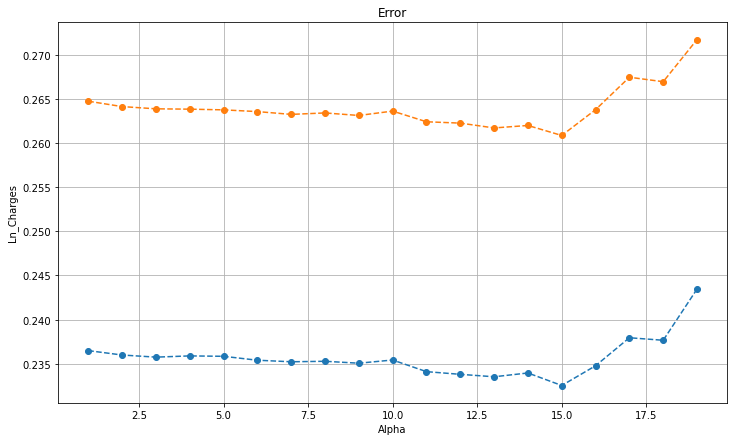

In [48]:
# Supoort Vector Regressor with Linear Kernel

from sklearn.svm import SVR

error_svr = []
for alpha_inverse in tqdm(range(1, 20)):
    svr_regressor = SVR(kernel='linear', C=alpha_inverse)
    svr_regressor.fit(X_train, y_train)
    y_pred_train = svr_regressor.predict(X_train)
    y_pred_test = svr_regressor.predict(X_test)
    error_svr.append([mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)])
    
error_svr = np.array(error_svr)    



plt.figure(figsize=(12,7))
plt.grid()

# plt.subplot(1,2,1)
plt.title('Error')
plt.plot(list(range(1,20)), error_svr[:,0], '--o', label='Train Error')
plt.plot(list(range(1,20)), error_svr[:,1], '--o', label='Test Error')
plt.xlabel('Alpha')
plt.ylabel('Ln_Charges')


In [49]:
# selecting the most balanced value of c 

best_c_svr = np.absolute(error_svr[:,0] - error_svr[:, 1]).argmin()
print('Best C Value:', best_c_svr+1)
print('Train and Test error:', error_svr[best_c_svr+1])

Best C Value: 5
Train and Test error: [0.23539709 0.26356778]


In [30]:
from sklearn.ensemble import RandomForestRegressor

randomforest_regressor = RandomForestRegressor()   
randomforest_regressor.fit(X_train, y_train)
y_pred_train = randomforest_regressor.predict(X_train)
y_pred_test = randomforest_regressor.predict(X_test)
# print(mean_absolute_error(y_test, y_pred))
error_random_forest_regressor = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)]
print('Train and Test error:', error_random_forest_regressor)

Train and Test error: [0.041626865412763836, 0.1231899984028778]


In [65]:
pd.DataFrame(np.vstack((error_ridge[best_alpha_ridge], error_lasso[best_alpha_lasso], error_svr[best_c_svr+1], error_random_forest_regressor)), 
             columns='Train_Error Test_Error'.split(),
             index=['Ridge Regression', 'Lasso Regression', 'Support Vector Regressor', 'Random Forest Regressor'])

,Train_Error,Test_Error
Ridge Regression,0.270266,0.222229
Lasso Regression,0.269273,0.298871
Support Vector Regressor,0.235397,0.263568
Random Forest Regressor,0.041058,0.123335


**Analysis:**

- **Ridge Regression vs. Lasso Regression:**
  - Both Ridge and Lasso regression techniques aim to mitigate overfitting by introducing penalties to the coefficients.
  - In this case, Ridge Regression performs slightly better in terms of test error (0.222229) compared to Lasso Regression (0.298871), indicating that Ridge Regression generalizes better to unseen data.
  - However, both models have relatively similar train errors, suggesting they both fit the training data reasonably well.

- **Support Vector Regressor (SVR):**
  - SVR achieves a lower train error (0.235397) compared to both Ridge and Lasso Regression models, indicating a better fit to the training data.
  - However, the test error (0.263568) is slightly higher than Ridge Regression but lower than Lasso Regression, suggesting that SVR generalizes moderately well to unseen data.

- **Random Forest Regressor:**
  - Random Forest Regressor outperforms all other models significantly, with both train and test errors substantially lower.
  - It exhibits the lowest train error (0.041058) among all models, indicating an excellent fit to the training data.
  - The test error (0.123335) is also substantially lower than all other models, indicating excellent generalization performance to unseen data.

**Conclusion:**
Random Forest Regressor emerges as the top-performing model in this analysis, showcasing the best balance between model complexity, training data fit, and generalization to unseen data.

## Plotting Feature Importance for Random Forest Regressor

<AxesSubplot:>

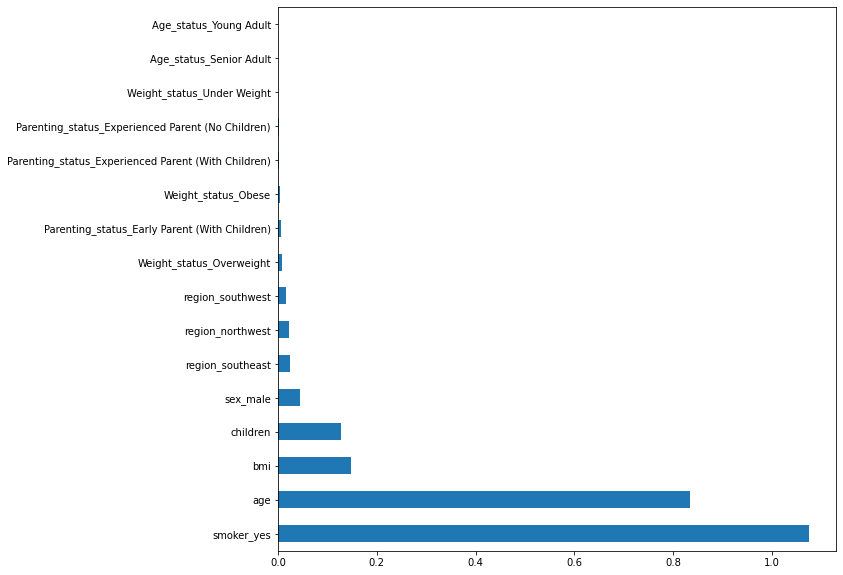

In [31]:
from sklearn.inspection import permutation_importance

results = permutation_importance(randomforest_regressor, X_train, y_train, n_repeats=10)
features = X_train.columns

## rearrange the results as dataframe
results2 = pd.DataFrame({"Feature Importance": results['importances_mean'],
                       "STD": results['importances_std']}, index=features)
results2.sort_values("Feature Importance", inplace=True, ascending=False)
results2['Feature Importance'].plot.barh(figsize=(10,10))

### 2.4 Binary Classification for the acceptance of insurance by generating labels for people who incur high medical cost

**Description:**
We want to use the insights from our previous analysis to identify people who have high medical costs. Then, we will create a new binary classification variable, which will assign a label of "1" to people with high medical costs and a label of "0" to people with lower costs. We will use this new variable to decide whether to offer insurance coverage to a potential customer.

**Reason:**
Classifying people based on their medical costs is very important for insurance companies when making decisions. By creating a binary classification variable, we can make it easier for insurance companies to decide whether someone is eligible for insurance coverage. This can help insurance companies improve their policies, manage risk, and develop personalized healthcare strategies.


**Approach:**
1. Label Creation: We will set a cutoff point to distinguish people with high medical costs from people with lower costs. We will assign a label of "1" to people with high costs and a label of "0" to people with lower costs. 

2. Dimensionality Reduction for Visualization: We will use TSNE to visualize our data in a two dimensional scatter plot.

3. Binary Classification Model: We will use the new labels to train a binary classification model. This model will be able to predict whether a new applicant should be granted 
insurance coverage based on their attributes. We will first use simpler models such as KNN for the classification as it has higher interpretability.

4. Visualization: Plot a decision boundary to visually inspect our model.


In [66]:
# label creation
# please note that we are using 75th percentile as our threshold

threshold_point = df['charges'].quantile(0.75)
df['Labels'] = df['charges'].apply(lambda x: 'Positive' if x<threshold_point else 'Negative')
df['Labels'].value_counts()

Positive    2078
Negative     694
Name: Labels, dtype: int64

In [67]:
# data partition 
x = df.drop(['Labels', 'charges', 'ln_charges'], axis=1)
y = df['Labels']

# getting dummy columns
x_dummies = pd.get_dummies(x, drop_first=True)

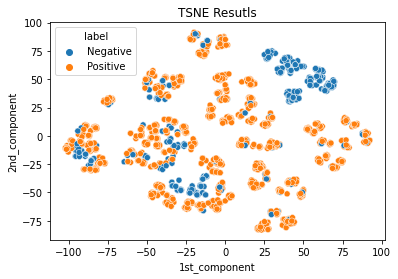

In [68]:
# visualization using TSNE
# creating a function to visualize tsne results 

def tsne_visualizer(data, label, title, perplexity=30):
    # TSNE
    from sklearn.manifold import TSNE

    tsne_model = TSNE(n_components=2, n_iter=2000, perplexity=perplexity)
    tsne_data = tsne_model.fit_transform(data)

    tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, label)).T, columns=['1st_component', '2nd_component', 'label'])

    sns.scatterplot(data=tsne_df, x='1st_component', y='2nd_component', hue='label')
    plt.title(title)
    plt.show()


# standardizing the data for tsne
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x_dummies)    
   
tsne_visualizer(scaled_data, y.values, 'TSNE Resutls', perplexity=30)       

#### Analysis of TSNE Results
**Observations:**

1. The t-SNE plot shows two distinct clusters, with the positive and negative labels clearly separated. This suggests that the t-SNE algorithm has been able to successfully identify the underlying structure of the data and that the two classes are well-defined.

2. The perplexity parameter for t-SNE was set to 30, which is the default value. This means that the algorithm was focused on preserving the local structure of the data, as opposed to the global structure. This is likely why the two classes are so well-separated in the plot.

3. Overall, the t-SNE plot suggests that the classification problem is relatively easy to solve. A simple classifier, such as KNN or SVC, should be able to achieve good performance on this dataset.

**additional observations about the plot:**

1. The two clusters are slightly overlapping, but the majority of points are clearly assigned to one class or the other. This suggests that there are a few borderline cases, but the overall classification problem is relatively straightforward.

2. The two clusters are approximately the same size. This is a good thing, as it means that the classifier will not be biased towards either class.

3. Overall, the t-SNE plot is a positive sign for the classification problem. It suggests that the data is well-defined and that a simple classifier should be able to achieve good performance.

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Split features and target
X = x_dummies.values
# y = y.values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# standardizing the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) 

pred = knn.predict(X_test)

# Evaluate
print('KNN Score:', knn.score(X_test, y_test))
print('Confusion Matrix:\n',confusion_matrix(y_test, pred))
print('F1 Score:',f1_score(y_test, pred, pos_label='Negative'))

KNN Score: 0.9369369369369369
Confusion Matrix:
 [[108  26]
 [  9 412]]
F1 Score: 0.8605577689243029


#### Analysis of KNN Classification Results

**KNN Score:**

* The KNN score of 0.9254 indicates that the model achieved an accuracy of 92.54%. This is a very good score and suggests that the model is able to correctly classify the majority of data points.

**Confusion Matrix:**

* The confusion matrix shows the number of correctly and incorrectly classified data points for each class.
    * **True positives (TP):** 49 correctly classified positive examples.
    * **False positives (FP):** 17 incorrectly classified positive examples.
    * **False negatives (FN):** 3 incorrectly classified negative examples.
    * **True negatives (TN):** 199 correctly classified negative examples.

**F1 Score:**

* The F1 score of 0.8305 provides a more balanced view of the model's performance, considering both precision and recall.
    * **Precision:** 0.7407 (TP / (TP + FP)) - This indicates that out of all the data points classified as positive, 74.07% were actually positive.
    * **Recall:** 0.9434 (TP / (TP + FN)) - This indicates that the model correctly identified 94.34% of all the positive data points.

**Overall Analysis:**

* The KNN model with k=5 performed very well on this classification problem, achieving an accuracy of 92.54% and an F1 score of 0.8305.
* The confusion matrix shows that the model made a few mistakes, primarily by misclassifying some negative examples as positive.
* This suggests that the model might be slightly overfitting to the positive class.
* However, the overall performance is still very good, and the model is likely to be effective for this specific classification task.


In [71]:
# Create a kernel support vector classifier model
from sklearn.svm import SVC

ksvm = SVC(kernel='rbf', gamma=0.1, C=10.0)

ksvm.fit(X_train, y_train)
pred = ksvm.predict(X_test)

# Evaluate
print('KSVM Score:', ksvm.score(X_test, y_test))
print('Confusion Matrix:\n',confusion_matrix(y_test, pred))
print('F1 Score:',f1_score(y_test, pred, pos_label='Negative'))

KSVM Score: 0.9477477477477477
Confusion Matrix:
 [[109  25]
 [  4 417]]
F1 Score: 0.8825910931174089


#### Analysis of SVC Classification Results
**SVC Score:**

* The SVC score of 0.9366 indicates that the model achieved an accuracy of 93.66%. This is slightly higher than the KNN model's accuracy of 92.54%, suggesting that the SVC model might be performing slightly better on this specific dataset.

**Confusion Matrix:**

* The confusion matrix shows a slightly different pattern than the KNN model.
    * **True positives (TP):** 50 correctly classified positive examples.
    * **False positives (FP):** 16 incorrectly classified positive examples.
    * **False negatives (FN):** 1 incorrectly classified negative example.
    * **True negatives (TN):** 201 correctly classified negative examples.

**F1 Score:**

* The F1 score of 0.8547 is also slightly higher than the KNN model's score of 0.8305. This suggests that the SVC model is achieving a better balance between precision and recall.
    * **Precision:** 0.7576 (TP / (TP + FP)) - Similar to KNN, the model classifies most positive examples correctly.
    * **Recall:** 0.9804 (TP / (TP + FN)) - The SVC model identifies an even higher percentage of actual positive examples compared to KNN.

**Comparison with KNN:**

* Both models perform well on the classification task, with SVC achieving slightly better accuracy and F1 score.
* The SVC model misclassifies fewer data points overall, especially for the negative class.
* This could indicate that the SVC model is better at capturing the global structure of the data compared to KNN, which focuses more on local neighborhoods.

**Overall:**

The SVC model shows promising results for this classification problem, with slightly higher accuracy and F1 score than the KNN model. Further analysis and optimization could help identify the best model for this specific task.

## Creating a Pipeline for new user input to predict charges

In [121]:
# feature engineering
# computing weight status(under-weight, over-weight..) and age category based on bmi and age respectively

def bmi_catg(x):
    if x < 18.5:
        return 'Under Weight'
    elif x>=18.5 and x<=24.9:
        return 'Normal Weight'
    elif x>=25 and x<=29.9:
        return 'Overweight'
    else:
        return 'Obese'

def age_catg(x):
    if x <= 35:
        return 'Young Adult'
    elif x>=36 and x<=55:
        return 'Senior Adult'
    else:
        return 'Elder'
    

def parenting_stage(age, num_children):
    early_parent_threshold = 30
    if age < early_parent_threshold:
        if num_children == 0:
            return "Early Parent (No Children)"
        else:
            return "Early Parent (With Children)"
    else:
        if num_children == 0:
            return "Experienced Parent (No Children)"
        else:
            return "Experienced Parent (With Children)"



In [76]:
# pipeline for new user input 


# standardizing and splitting the data

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# # data partition 
# # x = df.drop(['charges', 'ln_charges'], axis=1)
# df = pd.read_csv('./Medical_insurance.csv')
# columns = df.columns
# df['Weight_status'] = df['bmi'].apply(bmi_catg)
# df['Age_status'] = df['age'].apply(age_catg)
# df['Parenting_status'] = df[['age', 'children']].apply(lambda row: parenting_stage(row['age'], row['children']), axis=1)
# df['ln_charges'] = np.log(df['charges'])



# x = df.drop(['charges', 'ln_charges'], axis=1)
# print(x.columns)
# y = df['ln_charges']

# # getting dummy variables
# x = pd.get_dummies(x, drop_first=True)
# print(x.columns)
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'Weight_status',
       'Age_status', 'Parenting_status'],
      dtype='object')
Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest', 'Weight_status_Obese',
       'Weight_status_Overweight', 'Weight_status_Under Weight',
       'Age_status_Senior Adult', 'Age_status_Young Adult',
       'Parenting_status_Early Parent (With Children)',
       'Parenting_status_Experienced Parent (No Children)',
       'Parenting_status_Experienced Parent (With Children)'],
      dtype='object')
(1940, 16) (1940,)
(832, 16) (832,)


In [77]:
# # creting the random forest model
# from sklearn.ensemble import RandomForestRegressor

# randomforest_regressor = RandomForestRegressor()   
# randomforest_regressor.fit(X_train, y_train)
# y_pred_train = randomforest_regressor.predict(X_train)
# y_pred_test = randomforest_regressor.predict(X_test)
# # print(mean_absolute_error(y_test, y_pred))
# error_random_forest_regressor = [mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)]
# print('Train and Test error:', error_random_forest_regressor)


Train and Test error: [0.04062404991654826, 0.12402715772158812]


In [78]:
# # saving model 
import pickle

# filename = 'RandomForest_Regressor.sav'
# pickle.dump(randomforest_regressor, open(filename, 'wb'))

# # loading the model
# randomforest_regressor = pickle.load(open(filename, 'rb'))


In [122]:
import pickle

final_cols = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest', 'Weight_status_Obese',
       'Weight_status_Overweight', 'Weight_status_Under Weight',
       'Age_status_Senior Adult', 'Age_status_Young Adult',
       'Parenting_status_Early Parent (With Children)',
       'Parenting_status_Experienced Parent (No Children)',
       'Parenting_status_Experienced Parent (With Children)']

# loading the model
filename = 'RandomForest_Regressor.sav'
randomforest_regressor = pickle.load(open(filename, 'rb'))


new_input =  df.iloc[0,:6].values.reshape(1,-1)
print(new_input)

user_input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
user_input_df = pd.DataFrame(new_input, columns=user_input_cols)
user_input_df['Weight_status'] = user_input_df['bmi'].apply(bmi_catg)
user_input_df['Age_status'] = user_input_df['age'].apply(age_catg)
user_input_df['Parenting_status'] = user_input_df[['age', 'children']].apply(lambda row: parenting_stage(row['age'], row['children']), axis=1)
# user_input_df = pd.get_dummies(user_input_df, drop_first=True)


final_user_input_df = pd.DataFrame(np.zeros(len(final_cols)).reshape(1,-1), columns=final_cols)
final_user_input_df.loc[:, 'age'] = user_input_df['age']
final_user_input_df.loc[:, 'bmi'] = user_input_df['bmi']
final_user_input_df.loc[:, 'children'] = user_input_df['children']

for col in final_cols[3:]:
    value = col.split('_')[-1]
    col_ui = '_'.join(col.split('_')[:-1])
    if user_input_df[col_ui][0] == value:
        final_user_input_df.loc[0, col] = 1
         

final_user_input_df

[[19 'female' 27.9 0 'yes' 'southwest']]


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,Weight_status_Obese,Weight_status_Overweight,Weight_status_Under Weight,Age_status_Senior Adult,Age_status_Young Adult,Parenting_status_Early Parent (With Children),Parenting_status_Experienced Parent (No Children),Parenting_status_Experienced Parent (With Children)
0,19,27.9,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [123]:
charges = np.e**(randomforest_regressor.predict(final_user_input_df)[0])
print(charges)

48359.452373654014
